# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.20KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

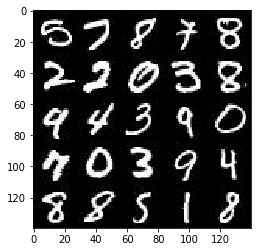

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

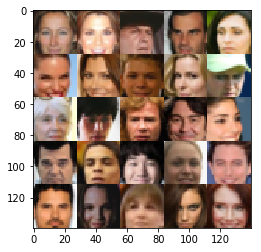

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return real_input, z_data, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)
        
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha * l3, l3)
        
        flat = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 2*2*512)
        l1 = tf.reshape(l1, (-1, 2, 2, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='valid')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)

        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    real_input, z_input, lr = model_inputs(
        img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    n_images = 25
    print_at_step= 10
    show_at_step = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        real_input: batch_images, z_input: z_sample})
                
                if steps % print_at_step == 0:
                    train_loss_d = d_loss.eval({z_input: z_sample, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.3f}...".format(train_loss_d),
                          "Generator Loss: {:.3f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_at_step == 0:
                    show_generator_output(sess, n_images, z_input, img_channels, data_image_mode)
                   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.812... Generator Loss: 0.552
Epoch 1/2... Discriminator Loss: 2.770... Generator Loss: 3.158
Epoch 1/2... Discriminator Loss: 1.775... Generator Loss: 3.739
Epoch 1/2... Discriminator Loss: 1.833... Generator Loss: 2.337
Epoch 1/2... Discriminator Loss: 1.486... Generator Loss: 0.934
Epoch 1/2... Discriminator Loss: 1.419... Generator Loss: 1.720
Epoch 1/2... Discriminator Loss: 1.362... Generator Loss: 1.408
Epoch 1/2... Discriminator Loss: 1.393... Generator Loss: 1.317
Epoch 1/2... Discriminator Loss: 1.439... Generator Loss: 1.489
Epoch 1/2... Discriminator Loss: 1.256... Generator Loss: 1.363


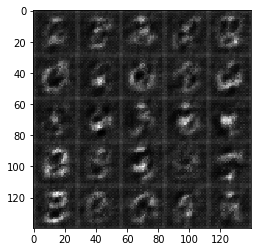

Epoch 1/2... Discriminator Loss: 1.322... Generator Loss: 1.197
Epoch 1/2... Discriminator Loss: 1.535... Generator Loss: 1.428
Epoch 1/2... Discriminator Loss: 1.333... Generator Loss: 1.402
Epoch 1/2... Discriminator Loss: 1.242... Generator Loss: 1.305
Epoch 1/2... Discriminator Loss: 1.277... Generator Loss: 1.331
Epoch 1/2... Discriminator Loss: 1.347... Generator Loss: 1.524
Epoch 1/2... Discriminator Loss: 1.256... Generator Loss: 1.581
Epoch 1/2... Discriminator Loss: 1.250... Generator Loss: 1.580
Epoch 1/2... Discriminator Loss: 1.144... Generator Loss: 1.476
Epoch 1/2... Discriminator Loss: 1.184... Generator Loss: 1.433


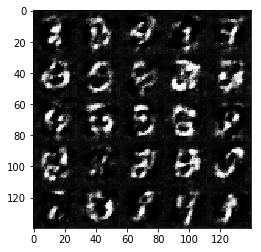

Epoch 1/2... Discriminator Loss: 1.156... Generator Loss: 1.465
Epoch 1/2... Discriminator Loss: 1.132... Generator Loss: 1.571
Epoch 1/2... Discriminator Loss: 1.376... Generator Loss: 1.978
Epoch 1/2... Discriminator Loss: 1.003... Generator Loss: 1.539
Epoch 1/2... Discriminator Loss: 1.069... Generator Loss: 1.435
Epoch 1/2... Discriminator Loss: 1.252... Generator Loss: 1.277
Epoch 1/2... Discriminator Loss: 1.336... Generator Loss: 1.554
Epoch 1/2... Discriminator Loss: 1.218... Generator Loss: 1.581
Epoch 1/2... Discriminator Loss: 1.194... Generator Loss: 1.427
Epoch 1/2... Discriminator Loss: 1.104... Generator Loss: 1.466


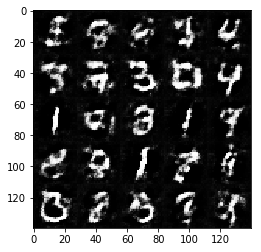

Epoch 1/2... Discriminator Loss: 1.215... Generator Loss: 1.468
Epoch 1/2... Discriminator Loss: 1.114... Generator Loss: 1.170
Epoch 1/2... Discriminator Loss: 1.187... Generator Loss: 1.478
Epoch 1/2... Discriminator Loss: 1.323... Generator Loss: 1.500
Epoch 1/2... Discriminator Loss: 1.182... Generator Loss: 1.354
Epoch 1/2... Discriminator Loss: 1.347... Generator Loss: 1.662
Epoch 1/2... Discriminator Loss: 1.098... Generator Loss: 1.253
Epoch 1/2... Discriminator Loss: 1.367... Generator Loss: 1.559
Epoch 1/2... Discriminator Loss: 1.197... Generator Loss: 1.311
Epoch 1/2... Discriminator Loss: 1.154... Generator Loss: 1.398


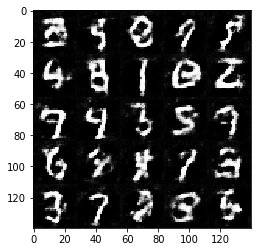

Epoch 1/2... Discriminator Loss: 1.184... Generator Loss: 1.342
Epoch 1/2... Discriminator Loss: 1.323... Generator Loss: 1.644
Epoch 1/2... Discriminator Loss: 1.141... Generator Loss: 1.499
Epoch 1/2... Discriminator Loss: 1.038... Generator Loss: 1.260
Epoch 1/2... Discriminator Loss: 1.140... Generator Loss: 1.300
Epoch 1/2... Discriminator Loss: 1.158... Generator Loss: 1.478
Epoch 1/2... Discriminator Loss: 1.229... Generator Loss: 1.419
Epoch 1/2... Discriminator Loss: 1.093... Generator Loss: 1.370
Epoch 1/2... Discriminator Loss: 1.110... Generator Loss: 1.314
Epoch 1/2... Discriminator Loss: 1.071... Generator Loss: 0.988


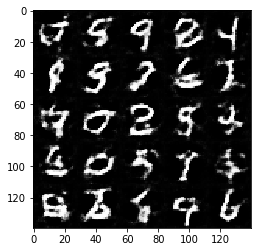

Epoch 1/2... Discriminator Loss: 1.229... Generator Loss: 1.432
Epoch 1/2... Discriminator Loss: 1.045... Generator Loss: 1.134
Epoch 1/2... Discriminator Loss: 0.991... Generator Loss: 1.072
Epoch 1/2... Discriminator Loss: 1.163... Generator Loss: 1.301
Epoch 1/2... Discriminator Loss: 1.219... Generator Loss: 1.388
Epoch 1/2... Discriminator Loss: 1.172... Generator Loss: 0.496
Epoch 1/2... Discriminator Loss: 1.055... Generator Loss: 0.666
Epoch 1/2... Discriminator Loss: 1.310... Generator Loss: 0.417
Epoch 1/2... Discriminator Loss: 1.079... Generator Loss: 0.591
Epoch 1/2... Discriminator Loss: 1.114... Generator Loss: 0.611


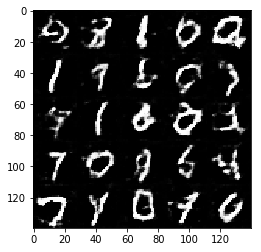

Epoch 1/2... Discriminator Loss: 1.238... Generator Loss: 0.467
Epoch 1/2... Discriminator Loss: 1.917... Generator Loss: 0.194
Epoch 1/2... Discriminator Loss: 0.985... Generator Loss: 0.726
Epoch 1/2... Discriminator Loss: 1.140... Generator Loss: 0.523
Epoch 1/2... Discriminator Loss: 1.238... Generator Loss: 0.461
Epoch 1/2... Discriminator Loss: 1.710... Generator Loss: 0.239
Epoch 1/2... Discriminator Loss: 1.202... Generator Loss: 0.507
Epoch 1/2... Discriminator Loss: 1.177... Generator Loss: 0.513
Epoch 1/2... Discriminator Loss: 1.688... Generator Loss: 0.272
Epoch 1/2... Discriminator Loss: 1.131... Generator Loss: 0.580


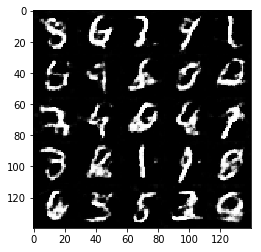

Epoch 1/2... Discriminator Loss: 1.005... Generator Loss: 0.807
Epoch 1/2... Discriminator Loss: 1.917... Generator Loss: 2.114
Epoch 1/2... Discriminator Loss: 1.037... Generator Loss: 0.899
Epoch 1/2... Discriminator Loss: 1.069... Generator Loss: 1.315
Epoch 1/2... Discriminator Loss: 0.953... Generator Loss: 1.340
Epoch 1/2... Discriminator Loss: 1.062... Generator Loss: 1.050
Epoch 1/2... Discriminator Loss: 0.906... Generator Loss: 1.169
Epoch 1/2... Discriminator Loss: 1.989... Generator Loss: 2.391
Epoch 1/2... Discriminator Loss: 1.080... Generator Loss: 0.666
Epoch 1/2... Discriminator Loss: 0.938... Generator Loss: 0.705


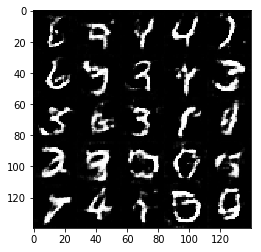

Epoch 1/2... Discriminator Loss: 1.412... Generator Loss: 0.348
Epoch 1/2... Discriminator Loss: 1.623... Generator Loss: 0.298
Epoch 1/2... Discriminator Loss: 1.012... Generator Loss: 0.611
Epoch 1/2... Discriminator Loss: 0.800... Generator Loss: 1.122
Epoch 1/2... Discriminator Loss: 1.095... Generator Loss: 1.458
Epoch 1/2... Discriminator Loss: 0.814... Generator Loss: 1.237
Epoch 1/2... Discriminator Loss: 1.595... Generator Loss: 2.369
Epoch 1/2... Discriminator Loss: 0.929... Generator Loss: 0.891
Epoch 1/2... Discriminator Loss: 0.906... Generator Loss: 0.867
Epoch 1/2... Discriminator Loss: 0.818... Generator Loss: 1.032


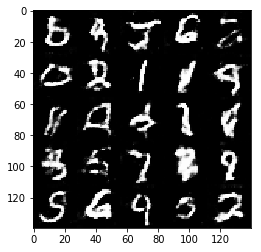

Epoch 1/2... Discriminator Loss: 1.894... Generator Loss: 2.580
Epoch 1/2... Discriminator Loss: 0.930... Generator Loss: 1.162
Epoch 1/2... Discriminator Loss: 0.963... Generator Loss: 0.681
Epoch 2/2... Discriminator Loss: 1.176... Generator Loss: 1.446
Epoch 2/2... Discriminator Loss: 1.067... Generator Loss: 1.163
Epoch 2/2... Discriminator Loss: 1.448... Generator Loss: 0.334
Epoch 2/2... Discriminator Loss: 1.075... Generator Loss: 0.631
Epoch 2/2... Discriminator Loss: 0.925... Generator Loss: 1.015
Epoch 2/2... Discriminator Loss: 1.650... Generator Loss: 2.294
Epoch 2/2... Discriminator Loss: 0.997... Generator Loss: 1.412


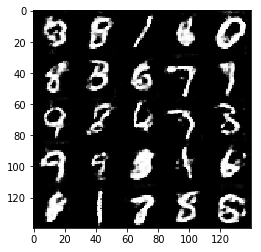

Epoch 2/2... Discriminator Loss: 1.020... Generator Loss: 1.997
Epoch 2/2... Discriminator Loss: 1.093... Generator Loss: 1.671
Epoch 2/2... Discriminator Loss: 1.120... Generator Loss: 0.586
Epoch 2/2... Discriminator Loss: 1.019... Generator Loss: 0.574
Epoch 2/2... Discriminator Loss: 1.490... Generator Loss: 0.315
Epoch 2/2... Discriminator Loss: 1.226... Generator Loss: 0.469
Epoch 2/2... Discriminator Loss: 1.184... Generator Loss: 0.541
Epoch 2/2... Discriminator Loss: 1.378... Generator Loss: 0.354
Epoch 2/2... Discriminator Loss: 1.337... Generator Loss: 0.429
Epoch 2/2... Discriminator Loss: 1.145... Generator Loss: 0.481


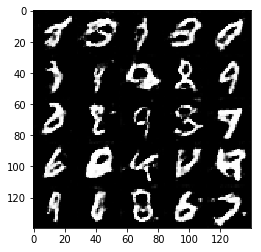

Epoch 2/2... Discriminator Loss: 1.491... Generator Loss: 0.312
Epoch 2/2... Discriminator Loss: 1.201... Generator Loss: 0.474
Epoch 2/2... Discriminator Loss: 0.842... Generator Loss: 1.010
Epoch 2/2... Discriminator Loss: 2.376... Generator Loss: 0.139
Epoch 2/2... Discriminator Loss: 1.039... Generator Loss: 0.579
Epoch 2/2... Discriminator Loss: 0.730... Generator Loss: 1.118
Epoch 2/2... Discriminator Loss: 0.944... Generator Loss: 1.335
Epoch 2/2... Discriminator Loss: 0.940... Generator Loss: 1.854
Epoch 2/2... Discriminator Loss: 0.894... Generator Loss: 1.241
Epoch 2/2... Discriminator Loss: 1.109... Generator Loss: 0.571


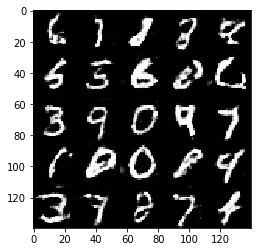

Epoch 2/2... Discriminator Loss: 1.250... Generator Loss: 0.469
Epoch 2/2... Discriminator Loss: 1.447... Generator Loss: 0.346
Epoch 2/2... Discriminator Loss: 1.135... Generator Loss: 0.528
Epoch 2/2... Discriminator Loss: 0.650... Generator Loss: 1.195
Epoch 2/2... Discriminator Loss: 0.717... Generator Loss: 1.109
Epoch 2/2... Discriminator Loss: 0.675... Generator Loss: 1.095
Epoch 2/2... Discriminator Loss: 2.244... Generator Loss: 0.146
Epoch 2/2... Discriminator Loss: 1.195... Generator Loss: 0.434
Epoch 2/2... Discriminator Loss: 1.664... Generator Loss: 0.272
Epoch 2/2... Discriminator Loss: 1.311... Generator Loss: 0.408


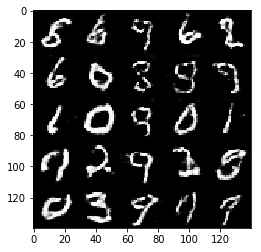

Epoch 2/2... Discriminator Loss: 0.949... Generator Loss: 0.783
Epoch 2/2... Discriminator Loss: 0.775... Generator Loss: 1.439
Epoch 2/2... Discriminator Loss: 1.077... Generator Loss: 1.178
Epoch 2/2... Discriminator Loss: 0.911... Generator Loss: 0.992
Epoch 2/2... Discriminator Loss: 1.334... Generator Loss: 0.461
Epoch 2/2... Discriminator Loss: 2.187... Generator Loss: 0.151
Epoch 2/2... Discriminator Loss: 1.230... Generator Loss: 0.473
Epoch 2/2... Discriminator Loss: 0.808... Generator Loss: 0.969
Epoch 2/2... Discriminator Loss: 0.870... Generator Loss: 0.715
Epoch 2/2... Discriminator Loss: 1.858... Generator Loss: 0.234


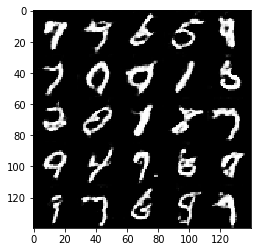

Epoch 2/2... Discriminator Loss: 1.107... Generator Loss: 0.510
Epoch 2/2... Discriminator Loss: 2.012... Generator Loss: 0.198
Epoch 2/2... Discriminator Loss: 0.664... Generator Loss: 1.130
Epoch 2/2... Discriminator Loss: 0.800... Generator Loss: 0.832
Epoch 2/2... Discriminator Loss: 1.866... Generator Loss: 0.216
Epoch 2/2... Discriminator Loss: 1.321... Generator Loss: 0.443
Epoch 2/2... Discriminator Loss: 0.833... Generator Loss: 0.794
Epoch 2/2... Discriminator Loss: 0.597... Generator Loss: 1.187
Epoch 2/2... Discriminator Loss: 1.741... Generator Loss: 0.262
Epoch 2/2... Discriminator Loss: 1.017... Generator Loss: 0.616


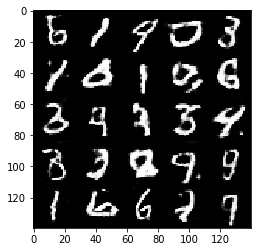

Epoch 2/2... Discriminator Loss: 1.902... Generator Loss: 0.199
Epoch 2/2... Discriminator Loss: 0.907... Generator Loss: 0.722
Epoch 2/2... Discriminator Loss: 0.855... Generator Loss: 0.840
Epoch 2/2... Discriminator Loss: 0.604... Generator Loss: 1.228
Epoch 2/2... Discriminator Loss: 1.002... Generator Loss: 0.577
Epoch 2/2... Discriminator Loss: 1.425... Generator Loss: 0.357
Epoch 2/2... Discriminator Loss: 1.526... Generator Loss: 0.297
Epoch 2/2... Discriminator Loss: 0.856... Generator Loss: 1.884
Epoch 2/2... Discriminator Loss: 0.839... Generator Loss: 1.397
Epoch 2/2... Discriminator Loss: 0.762... Generator Loss: 0.832


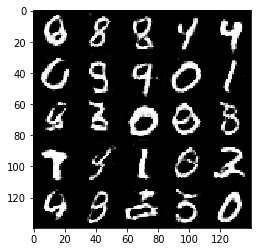

Epoch 2/2... Discriminator Loss: 0.899... Generator Loss: 0.658
Epoch 2/2... Discriminator Loss: 1.853... Generator Loss: 0.226
Epoch 2/2... Discriminator Loss: 1.787... Generator Loss: 0.255
Epoch 2/2... Discriminator Loss: 1.307... Generator Loss: 0.409
Epoch 2/2... Discriminator Loss: 0.710... Generator Loss: 1.391
Epoch 2/2... Discriminator Loss: 0.999... Generator Loss: 0.616
Epoch 2/2... Discriminator Loss: 1.721... Generator Loss: 0.244
Epoch 2/2... Discriminator Loss: 1.337... Generator Loss: 0.431
Epoch 2/2... Discriminator Loss: 0.850... Generator Loss: 0.844
Epoch 2/2... Discriminator Loss: 1.228... Generator Loss: 0.464


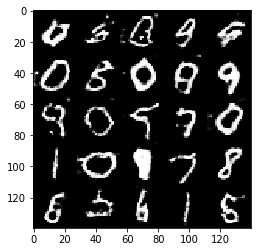

Epoch 2/2... Discriminator Loss: 1.296... Generator Loss: 0.511
Epoch 2/2... Discriminator Loss: 1.428... Generator Loss: 0.346
Epoch 2/2... Discriminator Loss: 1.000... Generator Loss: 0.586
Epoch 2/2... Discriminator Loss: 0.625... Generator Loss: 1.199
Epoch 2/2... Discriminator Loss: 1.111... Generator Loss: 0.556
Epoch 2/2... Discriminator Loss: 0.922... Generator Loss: 0.692
Epoch 2/2... Discriminator Loss: 0.582... Generator Loss: 1.381
Epoch 2/2... Discriminator Loss: 1.254... Generator Loss: 0.410
Epoch 2/2... Discriminator Loss: 2.286... Generator Loss: 0.150
Epoch 2/2... Discriminator Loss: 1.307... Generator Loss: 0.406


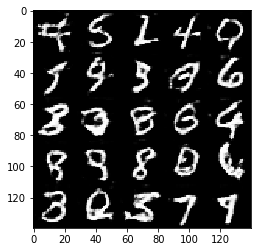

Epoch 2/2... Discriminator Loss: 1.085... Generator Loss: 0.500
Epoch 2/2... Discriminator Loss: 0.940... Generator Loss: 0.678
Epoch 2/2... Discriminator Loss: 2.225... Generator Loss: 0.149
Epoch 2/2... Discriminator Loss: 2.238... Generator Loss: 0.149
Epoch 2/2... Discriminator Loss: 0.843... Generator Loss: 0.723
Epoch 2/2... Discriminator Loss: 0.624... Generator Loss: 1.209
Epoch 2/2... Discriminator Loss: 0.973... Generator Loss: 0.615


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.972... Generator Loss: 0.000
Epoch 1/1... Discriminator Loss: 3.219... Generator Loss: 0.051
Epoch 1/1... Discriminator Loss: 3.848... Generator Loss: 0.035
Epoch 1/1... Discriminator Loss: 1.959... Generator Loss: 5.665
Epoch 1/1... Discriminator Loss: 1.618... Generator Loss: 1.741
Epoch 1/1... Discriminator Loss: 1.521... Generator Loss: 1.720
Epoch 1/1... Discriminator Loss: 1.409... Generator Loss: 1.952
Epoch 1/1... Discriminator Loss: 1.662... Generator Loss: 0.992
Epoch 1/1... Discriminator Loss: 1.428... Generator Loss: 1.701
Epoch 1/1... Discriminator Loss: 1.416... Generator Loss: 0.884


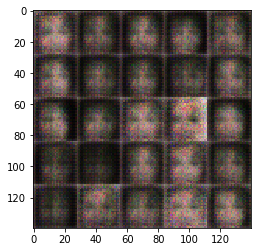

Epoch 1/1... Discriminator Loss: 1.451... Generator Loss: 1.193
Epoch 1/1... Discriminator Loss: 1.557... Generator Loss: 1.271
Epoch 1/1... Discriminator Loss: 1.832... Generator Loss: 1.121
Epoch 1/1... Discriminator Loss: 1.443... Generator Loss: 0.940
Epoch 1/1... Discriminator Loss: 1.445... Generator Loss: 1.234
Epoch 1/1... Discriminator Loss: 1.466... Generator Loss: 1.198
Epoch 1/1... Discriminator Loss: 1.280... Generator Loss: 1.307
Epoch 1/1... Discriminator Loss: 1.333... Generator Loss: 1.161
Epoch 1/1... Discriminator Loss: 1.406... Generator Loss: 0.897
Epoch 1/1... Discriminator Loss: 1.558... Generator Loss: 1.968


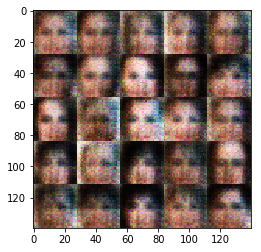

Epoch 1/1... Discriminator Loss: 1.356... Generator Loss: 1.238
Epoch 1/1... Discriminator Loss: 1.339... Generator Loss: 0.740
Epoch 1/1... Discriminator Loss: 1.577... Generator Loss: 0.404
Epoch 1/1... Discriminator Loss: 1.469... Generator Loss: 0.461
Epoch 1/1... Discriminator Loss: 1.713... Generator Loss: 0.280
Epoch 1/1... Discriminator Loss: 1.192... Generator Loss: 0.616
Epoch 1/1... Discriminator Loss: 1.510... Generator Loss: 0.344
Epoch 1/1... Discriminator Loss: 1.125... Generator Loss: 0.655
Epoch 1/1... Discriminator Loss: 1.417... Generator Loss: 0.442
Epoch 1/1... Discriminator Loss: 1.407... Generator Loss: 0.422


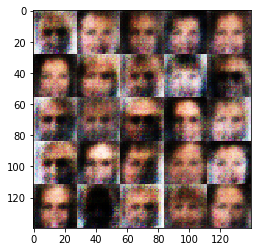

Epoch 1/1... Discriminator Loss: 1.246... Generator Loss: 0.619
Epoch 1/1... Discriminator Loss: 1.829... Generator Loss: 0.228
Epoch 1/1... Discriminator Loss: 1.361... Generator Loss: 0.510
Epoch 1/1... Discriminator Loss: 1.536... Generator Loss: 0.356
Epoch 1/1... Discriminator Loss: 1.357... Generator Loss: 1.833
Epoch 1/1... Discriminator Loss: 2.090... Generator Loss: 2.440
Epoch 1/1... Discriminator Loss: 1.252... Generator Loss: 1.668
Epoch 1/1... Discriminator Loss: 1.334... Generator Loss: 1.406
Epoch 1/1... Discriminator Loss: 1.310... Generator Loss: 1.097
Epoch 1/1... Discriminator Loss: 1.478... Generator Loss: 1.438


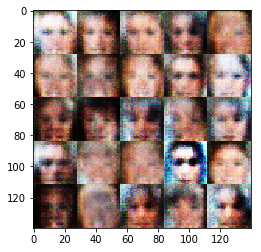

Epoch 1/1... Discriminator Loss: 1.132... Generator Loss: 1.369
Epoch 1/1... Discriminator Loss: 1.400... Generator Loss: 1.189
Epoch 1/1... Discriminator Loss: 1.066... Generator Loss: 1.504
Epoch 1/1... Discriminator Loss: 1.117... Generator Loss: 1.044
Epoch 1/1... Discriminator Loss: 1.250... Generator Loss: 1.195
Epoch 1/1... Discriminator Loss: 1.221... Generator Loss: 0.975
Epoch 1/1... Discriminator Loss: 1.875... Generator Loss: 1.589
Epoch 1/1... Discriminator Loss: 1.109... Generator Loss: 1.357
Epoch 1/1... Discriminator Loss: 1.516... Generator Loss: 1.438
Epoch 1/1... Discriminator Loss: 1.362... Generator Loss: 1.142


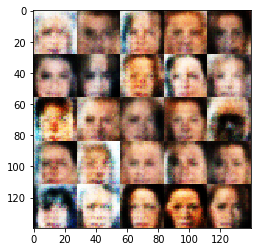

Epoch 1/1... Discriminator Loss: 1.460... Generator Loss: 1.066
Epoch 1/1... Discriminator Loss: 1.299... Generator Loss: 1.503
Epoch 1/1... Discriminator Loss: 1.384... Generator Loss: 2.113
Epoch 1/1... Discriminator Loss: 1.137... Generator Loss: 1.422
Epoch 1/1... Discriminator Loss: 1.241... Generator Loss: 1.773
Epoch 1/1... Discriminator Loss: 1.314... Generator Loss: 1.331
Epoch 1/1... Discriminator Loss: 1.245... Generator Loss: 2.242
Epoch 1/1... Discriminator Loss: 1.727... Generator Loss: 2.067
Epoch 1/1... Discriminator Loss: 1.144... Generator Loss: 0.937
Epoch 1/1... Discriminator Loss: 1.608... Generator Loss: 0.313


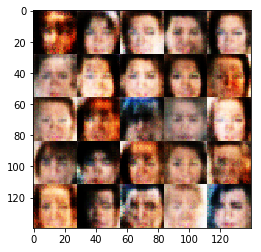

Epoch 1/1... Discriminator Loss: 0.712... Generator Loss: 1.846
Epoch 1/1... Discriminator Loss: 0.879... Generator Loss: 1.181
Epoch 1/1... Discriminator Loss: 1.238... Generator Loss: 1.024
Epoch 1/1... Discriminator Loss: 1.511... Generator Loss: 0.368
Epoch 1/1... Discriminator Loss: 0.973... Generator Loss: 1.986
Epoch 1/1... Discriminator Loss: 1.217... Generator Loss: 1.206
Epoch 1/1... Discriminator Loss: 0.989... Generator Loss: 2.324
Epoch 1/1... Discriminator Loss: 1.107... Generator Loss: 1.044
Epoch 1/1... Discriminator Loss: 2.420... Generator Loss: 0.128
Epoch 1/1... Discriminator Loss: 1.535... Generator Loss: 0.342


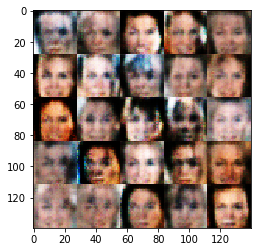

Epoch 1/1... Discriminator Loss: 1.144... Generator Loss: 0.681
Epoch 1/1... Discriminator Loss: 1.345... Generator Loss: 0.545
Epoch 1/1... Discriminator Loss: 0.847... Generator Loss: 1.376
Epoch 1/1... Discriminator Loss: 1.442... Generator Loss: 1.295
Epoch 1/1... Discriminator Loss: 1.081... Generator Loss: 1.664
Epoch 1/1... Discriminator Loss: 1.976... Generator Loss: 2.071
Epoch 1/1... Discriminator Loss: 1.088... Generator Loss: 1.214
Epoch 1/1... Discriminator Loss: 1.835... Generator Loss: 0.211
Epoch 1/1... Discriminator Loss: 1.088... Generator Loss: 0.558
Epoch 1/1... Discriminator Loss: 1.148... Generator Loss: 0.881


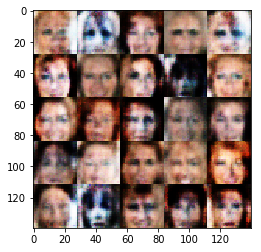

Epoch 1/1... Discriminator Loss: 1.261... Generator Loss: 0.984
Epoch 1/1... Discriminator Loss: 1.127... Generator Loss: 1.022
Epoch 1/1... Discriminator Loss: 1.449... Generator Loss: 1.157
Epoch 1/1... Discriminator Loss: 1.271... Generator Loss: 0.941
Epoch 1/1... Discriminator Loss: 1.319... Generator Loss: 0.916
Epoch 1/1... Discriminator Loss: 1.373... Generator Loss: 0.941
Epoch 1/1... Discriminator Loss: 2.240... Generator Loss: 2.533
Epoch 1/1... Discriminator Loss: 0.920... Generator Loss: 1.704
Epoch 1/1... Discriminator Loss: 1.314... Generator Loss: 0.521
Epoch 1/1... Discriminator Loss: 1.295... Generator Loss: 0.561


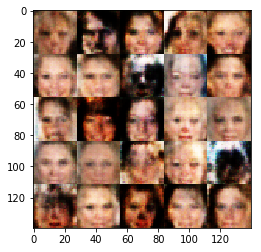

Epoch 1/1... Discriminator Loss: 0.748... Generator Loss: 1.235
Epoch 1/1... Discriminator Loss: 1.047... Generator Loss: 2.055
Epoch 1/1... Discriminator Loss: 1.057... Generator Loss: 1.855
Epoch 1/1... Discriminator Loss: 1.339... Generator Loss: 0.923
Epoch 1/1... Discriminator Loss: 1.308... Generator Loss: 1.223
Epoch 1/1... Discriminator Loss: 1.335... Generator Loss: 1.150
Epoch 1/1... Discriminator Loss: 0.889... Generator Loss: 1.752
Epoch 1/1... Discriminator Loss: 1.074... Generator Loss: 2.338
Epoch 1/1... Discriminator Loss: 0.893... Generator Loss: 1.197
Epoch 1/1... Discriminator Loss: 1.333... Generator Loss: 0.690


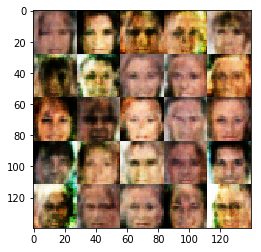

Epoch 1/1... Discriminator Loss: 0.956... Generator Loss: 1.045
Epoch 1/1... Discriminator Loss: 1.163... Generator Loss: 0.762
Epoch 1/1... Discriminator Loss: 1.520... Generator Loss: 0.721
Epoch 1/1... Discriminator Loss: 1.037... Generator Loss: 0.997
Epoch 1/1... Discriminator Loss: 1.351... Generator Loss: 0.545
Epoch 1/1... Discriminator Loss: 0.862... Generator Loss: 1.395
Epoch 1/1... Discriminator Loss: 0.940... Generator Loss: 2.142
Epoch 1/1... Discriminator Loss: 0.971... Generator Loss: 1.172
Epoch 1/1... Discriminator Loss: 1.300... Generator Loss: 0.856
Epoch 1/1... Discriminator Loss: 1.574... Generator Loss: 0.310


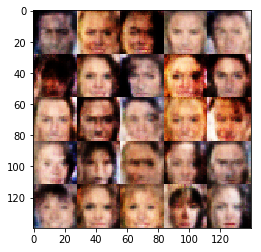

Epoch 1/1... Discriminator Loss: 1.130... Generator Loss: 0.646
Epoch 1/1... Discriminator Loss: 0.934... Generator Loss: 0.906
Epoch 1/1... Discriminator Loss: 1.862... Generator Loss: 1.854
Epoch 1/1... Discriminator Loss: 1.489... Generator Loss: 0.579
Epoch 1/1... Discriminator Loss: 1.082... Generator Loss: 1.191
Epoch 1/1... Discriminator Loss: 1.080... Generator Loss: 0.887
Epoch 1/1... Discriminator Loss: 1.324... Generator Loss: 0.646
Epoch 1/1... Discriminator Loss: 1.500... Generator Loss: 0.388
Epoch 1/1... Discriminator Loss: 0.779... Generator Loss: 1.635
Epoch 1/1... Discriminator Loss: 1.322... Generator Loss: 0.556


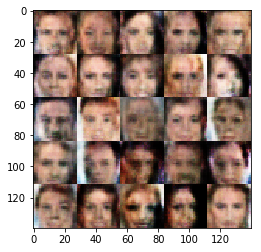

Epoch 1/1... Discriminator Loss: 1.385... Generator Loss: 0.706
Epoch 1/1... Discriminator Loss: 1.394... Generator Loss: 0.353
Epoch 1/1... Discriminator Loss: 2.070... Generator Loss: 2.386
Epoch 1/1... Discriminator Loss: 1.488... Generator Loss: 0.843
Epoch 1/1... Discriminator Loss: 0.707... Generator Loss: 1.975
Epoch 1/1... Discriminator Loss: 1.416... Generator Loss: 0.809
Epoch 1/1... Discriminator Loss: 1.015... Generator Loss: 1.118
Epoch 1/1... Discriminator Loss: 1.042... Generator Loss: 1.363
Epoch 1/1... Discriminator Loss: 1.246... Generator Loss: 1.122
Epoch 1/1... Discriminator Loss: 0.781... Generator Loss: 1.603


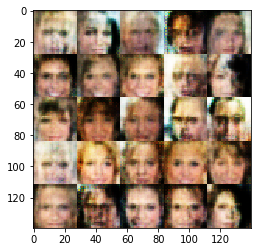

Epoch 1/1... Discriminator Loss: 1.323... Generator Loss: 0.669
Epoch 1/1... Discriminator Loss: 1.262... Generator Loss: 0.702
Epoch 1/1... Discriminator Loss: 0.984... Generator Loss: 1.415
Epoch 1/1... Discriminator Loss: 1.356... Generator Loss: 0.796
Epoch 1/1... Discriminator Loss: 1.088... Generator Loss: 0.938
Epoch 1/1... Discriminator Loss: 1.227... Generator Loss: 0.751
Epoch 1/1... Discriminator Loss: 1.619... Generator Loss: 0.277
Epoch 1/1... Discriminator Loss: 1.001... Generator Loss: 1.005
Epoch 1/1... Discriminator Loss: 1.342... Generator Loss: 0.770
Epoch 1/1... Discriminator Loss: 1.381... Generator Loss: 0.797


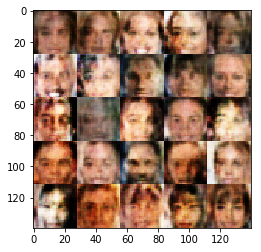

Epoch 1/1... Discriminator Loss: 1.135... Generator Loss: 1.219
Epoch 1/1... Discriminator Loss: 1.209... Generator Loss: 0.895
Epoch 1/1... Discriminator Loss: 0.978... Generator Loss: 0.807
Epoch 1/1... Discriminator Loss: 1.606... Generator Loss: 0.836
Epoch 1/1... Discriminator Loss: 1.725... Generator Loss: 0.280
Epoch 1/1... Discriminator Loss: 1.404... Generator Loss: 0.469
Epoch 1/1... Discriminator Loss: 1.117... Generator Loss: 0.772
Epoch 1/1... Discriminator Loss: 1.139... Generator Loss: 0.658
Epoch 1/1... Discriminator Loss: 1.294... Generator Loss: 0.524
Epoch 1/1... Discriminator Loss: 1.105... Generator Loss: 0.787


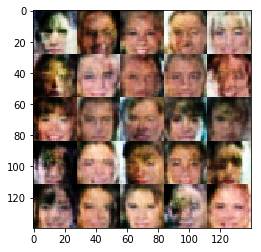

Epoch 1/1... Discriminator Loss: 1.174... Generator Loss: 0.762
Epoch 1/1... Discriminator Loss: 1.350... Generator Loss: 0.933
Epoch 1/1... Discriminator Loss: 0.811... Generator Loss: 1.771
Epoch 1/1... Discriminator Loss: 1.209... Generator Loss: 0.984
Epoch 1/1... Discriminator Loss: 1.326... Generator Loss: 0.663
Epoch 1/1... Discriminator Loss: 1.199... Generator Loss: 0.515
Epoch 1/1... Discriminator Loss: 1.288... Generator Loss: 0.680
Epoch 1/1... Discriminator Loss: 1.228... Generator Loss: 0.694
Epoch 1/1... Discriminator Loss: 0.936... Generator Loss: 0.727
Epoch 1/1... Discriminator Loss: 1.398... Generator Loss: 0.648


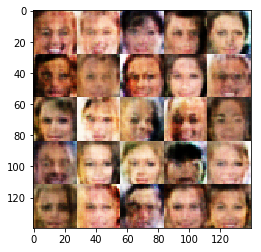

Epoch 1/1... Discriminator Loss: 2.326... Generator Loss: 0.119
Epoch 1/1... Discriminator Loss: 1.388... Generator Loss: 0.645
Epoch 1/1... Discriminator Loss: 1.097... Generator Loss: 0.838
Epoch 1/1... Discriminator Loss: 1.210... Generator Loss: 0.925
Epoch 1/1... Discriminator Loss: 1.277... Generator Loss: 1.028
Epoch 1/1... Discriminator Loss: 1.332... Generator Loss: 1.220
Epoch 1/1... Discriminator Loss: 1.232... Generator Loss: 1.484
Epoch 1/1... Discriminator Loss: 1.306... Generator Loss: 1.081
Epoch 1/1... Discriminator Loss: 1.252... Generator Loss: 2.298
Epoch 1/1... Discriminator Loss: 0.685... Generator Loss: 1.794


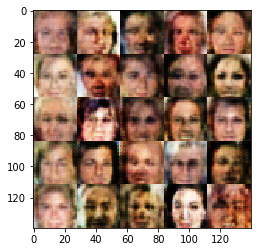

Epoch 1/1... Discriminator Loss: 1.261... Generator Loss: 1.205
Epoch 1/1... Discriminator Loss: 1.226... Generator Loss: 0.786
Epoch 1/1... Discriminator Loss: 1.372... Generator Loss: 1.000
Epoch 1/1... Discriminator Loss: 0.907... Generator Loss: 1.810
Epoch 1/1... Discriminator Loss: 1.333... Generator Loss: 0.644
Epoch 1/1... Discriminator Loss: 1.329... Generator Loss: 0.543
Epoch 1/1... Discriminator Loss: 0.742... Generator Loss: 1.177
Epoch 1/1... Discriminator Loss: 1.533... Generator Loss: 0.385
Epoch 1/1... Discriminator Loss: 1.449... Generator Loss: 0.418
Epoch 1/1... Discriminator Loss: 1.395... Generator Loss: 0.437


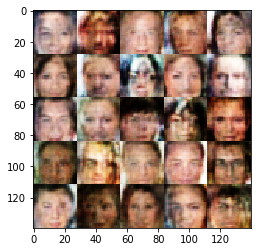

Epoch 1/1... Discriminator Loss: 1.170... Generator Loss: 1.507
Epoch 1/1... Discriminator Loss: 1.154... Generator Loss: 0.988
Epoch 1/1... Discriminator Loss: 1.677... Generator Loss: 0.288
Epoch 1/1... Discriminator Loss: 1.315... Generator Loss: 0.553
Epoch 1/1... Discriminator Loss: 1.613... Generator Loss: 0.312
Epoch 1/1... Discriminator Loss: 1.298... Generator Loss: 0.473
Epoch 1/1... Discriminator Loss: 0.530... Generator Loss: 2.389
Epoch 1/1... Discriminator Loss: 1.266... Generator Loss: 0.782
Epoch 1/1... Discriminator Loss: 1.516... Generator Loss: 0.369
Epoch 1/1... Discriminator Loss: 1.391... Generator Loss: 0.442


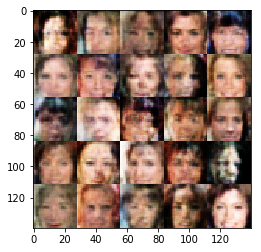

Epoch 1/1... Discriminator Loss: 1.851... Generator Loss: 0.210
Epoch 1/1... Discriminator Loss: 1.015... Generator Loss: 0.976
Epoch 1/1... Discriminator Loss: 1.348... Generator Loss: 0.696
Epoch 1/1... Discriminator Loss: 1.257... Generator Loss: 0.899
Epoch 1/1... Discriminator Loss: 1.157... Generator Loss: 0.829
Epoch 1/1... Discriminator Loss: 1.218... Generator Loss: 0.833
Epoch 1/1... Discriminator Loss: 0.972... Generator Loss: 0.993
Epoch 1/1... Discriminator Loss: 1.203... Generator Loss: 0.863
Epoch 1/1... Discriminator Loss: 1.301... Generator Loss: 0.492
Epoch 1/1... Discriminator Loss: 1.292... Generator Loss: 0.660


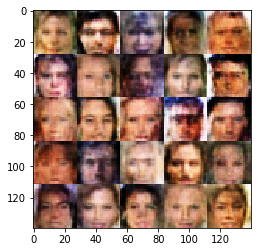

Epoch 1/1... Discriminator Loss: 1.512... Generator Loss: 0.313
Epoch 1/1... Discriminator Loss: 1.385... Generator Loss: 0.421
Epoch 1/1... Discriminator Loss: 1.196... Generator Loss: 0.813
Epoch 1/1... Discriminator Loss: 1.575... Generator Loss: 0.317
Epoch 1/1... Discriminator Loss: 1.107... Generator Loss: 3.105
Epoch 1/1... Discriminator Loss: 1.171... Generator Loss: 1.254
Epoch 1/1... Discriminator Loss: 0.824... Generator Loss: 0.853
Epoch 1/1... Discriminator Loss: 1.510... Generator Loss: 0.501
Epoch 1/1... Discriminator Loss: 1.339... Generator Loss: 0.738
Epoch 1/1... Discriminator Loss: 1.244... Generator Loss: 0.933


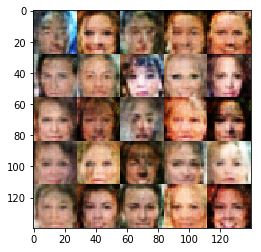

Epoch 1/1... Discriminator Loss: 1.245... Generator Loss: 0.838
Epoch 1/1... Discriminator Loss: 1.326... Generator Loss: 0.481
Epoch 1/1... Discriminator Loss: 1.521... Generator Loss: 0.349
Epoch 1/1... Discriminator Loss: 0.969... Generator Loss: 0.781
Epoch 1/1... Discriminator Loss: 1.287... Generator Loss: 0.627
Epoch 1/1... Discriminator Loss: 1.792... Generator Loss: 0.210
Epoch 1/1... Discriminator Loss: 1.343... Generator Loss: 0.650
Epoch 1/1... Discriminator Loss: 1.371... Generator Loss: 0.413
Epoch 1/1... Discriminator Loss: 1.038... Generator Loss: 1.003
Epoch 1/1... Discriminator Loss: 1.353... Generator Loss: 0.668


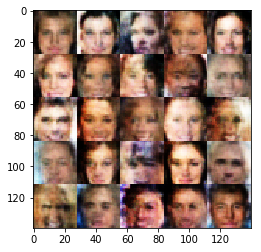

Epoch 1/1... Discriminator Loss: 1.372... Generator Loss: 0.628
Epoch 1/1... Discriminator Loss: 1.317... Generator Loss: 0.573
Epoch 1/1... Discriminator Loss: 1.099... Generator Loss: 0.711
Epoch 1/1... Discriminator Loss: 2.507... Generator Loss: 2.423
Epoch 1/1... Discriminator Loss: 1.321... Generator Loss: 0.839
Epoch 1/1... Discriminator Loss: 1.282... Generator Loss: 1.484
Epoch 1/1... Discriminator Loss: 1.616... Generator Loss: 0.288
Epoch 1/1... Discriminator Loss: 1.552... Generator Loss: 0.350
Epoch 1/1... Discriminator Loss: 2.014... Generator Loss: 0.193
Epoch 1/1... Discriminator Loss: 1.000... Generator Loss: 0.977


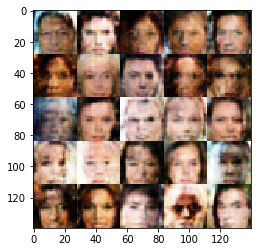

Epoch 1/1... Discriminator Loss: 1.289... Generator Loss: 0.760
Epoch 1/1... Discriminator Loss: 1.191... Generator Loss: 0.546
Epoch 1/1... Discriminator Loss: 1.428... Generator Loss: 0.489
Epoch 1/1... Discriminator Loss: 0.904... Generator Loss: 0.992
Epoch 1/1... Discriminator Loss: 1.329... Generator Loss: 0.743
Epoch 1/1... Discriminator Loss: 1.253... Generator Loss: 0.977
Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 0.698
Epoch 1/1... Discriminator Loss: 1.228... Generator Loss: 0.944
Epoch 1/1... Discriminator Loss: 1.119... Generator Loss: 0.789
Epoch 1/1... Discriminator Loss: 1.172... Generator Loss: 0.905


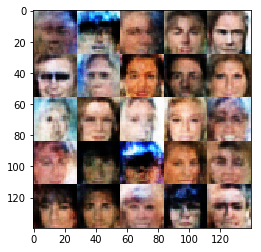

Epoch 1/1... Discriminator Loss: 1.729... Generator Loss: 0.270
Epoch 1/1... Discriminator Loss: 1.216... Generator Loss: 0.720
Epoch 1/1... Discriminator Loss: 1.265... Generator Loss: 0.466
Epoch 1/1... Discriminator Loss: 1.180... Generator Loss: 0.598
Epoch 1/1... Discriminator Loss: 1.111... Generator Loss: 0.721
Epoch 1/1... Discriminator Loss: 1.228... Generator Loss: 0.536
Epoch 1/1... Discriminator Loss: 1.106... Generator Loss: 0.651
Epoch 1/1... Discriminator Loss: 1.249... Generator Loss: 0.474
Epoch 1/1... Discriminator Loss: 1.354... Generator Loss: 0.450
Epoch 1/1... Discriminator Loss: 1.313... Generator Loss: 0.581


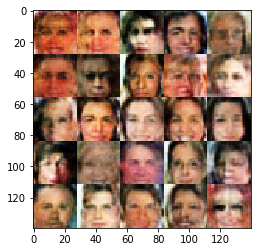

Epoch 1/1... Discriminator Loss: 1.384... Generator Loss: 0.399
Epoch 1/1... Discriminator Loss: 1.797... Generator Loss: 0.261
Epoch 1/1... Discriminator Loss: 1.410... Generator Loss: 0.874
Epoch 1/1... Discriminator Loss: 1.407... Generator Loss: 0.393
Epoch 1/1... Discriminator Loss: 1.544... Generator Loss: 0.350
Epoch 1/1... Discriminator Loss: 1.082... Generator Loss: 0.964
Epoch 1/1... Discriminator Loss: 1.134... Generator Loss: 0.783
Epoch 1/1... Discriminator Loss: 1.166... Generator Loss: 1.294
Epoch 1/1... Discriminator Loss: 1.066... Generator Loss: 1.546
Epoch 1/1... Discriminator Loss: 1.033... Generator Loss: 1.077


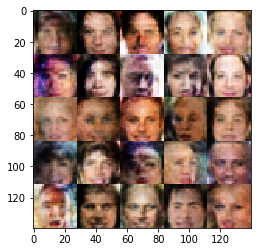

Epoch 1/1... Discriminator Loss: 1.078... Generator Loss: 0.833
Epoch 1/1... Discriminator Loss: 1.272... Generator Loss: 0.969
Epoch 1/1... Discriminator Loss: 0.947... Generator Loss: 1.202
Epoch 1/1... Discriminator Loss: 1.127... Generator Loss: 0.983
Epoch 1/1... Discriminator Loss: 1.267... Generator Loss: 0.779
Epoch 1/1... Discriminator Loss: 1.022... Generator Loss: 1.324
Epoch 1/1... Discriminator Loss: 1.229... Generator Loss: 0.729
Epoch 1/1... Discriminator Loss: 1.501... Generator Loss: 0.342
Epoch 1/1... Discriminator Loss: 1.121... Generator Loss: 0.826
Epoch 1/1... Discriminator Loss: 1.682... Generator Loss: 0.264


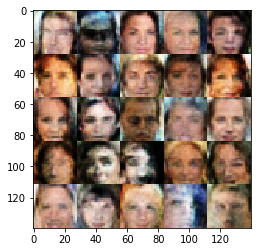

Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 0.606
Epoch 1/1... Discriminator Loss: 1.548... Generator Loss: 0.339
Epoch 1/1... Discriminator Loss: 1.098... Generator Loss: 1.121
Epoch 1/1... Discriminator Loss: 1.266... Generator Loss: 1.075
Epoch 1/1... Discriminator Loss: 1.049... Generator Loss: 1.572
Epoch 1/1... Discriminator Loss: 1.087... Generator Loss: 0.721
Epoch 1/1... Discriminator Loss: 1.639... Generator Loss: 0.738
Epoch 1/1... Discriminator Loss: 1.310... Generator Loss: 0.511
Epoch 1/1... Discriminator Loss: 1.239... Generator Loss: 0.477
Epoch 1/1... Discriminator Loss: 1.080... Generator Loss: 0.757


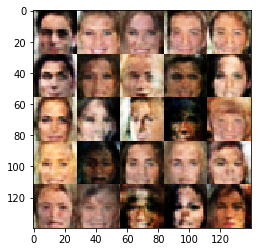

Epoch 1/1... Discriminator Loss: 1.430... Generator Loss: 0.434
Epoch 1/1... Discriminator Loss: 1.467... Generator Loss: 0.337
Epoch 1/1... Discriminator Loss: 2.145... Generator Loss: 0.168
Epoch 1/1... Discriminator Loss: 1.402... Generator Loss: 0.497
Epoch 1/1... Discriminator Loss: 1.297... Generator Loss: 0.422
Epoch 1/1... Discriminator Loss: 1.702... Generator Loss: 0.252
Epoch 1/1... Discriminator Loss: 0.975... Generator Loss: 0.783
Epoch 1/1... Discriminator Loss: 1.625... Generator Loss: 1.414
Epoch 1/1... Discriminator Loss: 1.470... Generator Loss: 0.411
Epoch 1/1... Discriminator Loss: 1.732... Generator Loss: 0.238


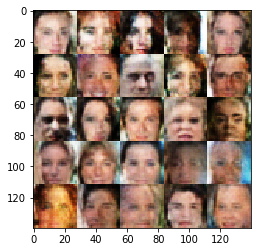

Epoch 1/1... Discriminator Loss: 1.217... Generator Loss: 0.710
Epoch 1/1... Discriminator Loss: 1.312... Generator Loss: 0.473
Epoch 1/1... Discriminator Loss: 1.388... Generator Loss: 0.448
Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 0.572
Epoch 1/1... Discriminator Loss: 1.338... Generator Loss: 1.571
Epoch 1/1... Discriminator Loss: 1.215... Generator Loss: 1.226
Epoch 1/1... Discriminator Loss: 1.242... Generator Loss: 0.777
Epoch 1/1... Discriminator Loss: 1.360... Generator Loss: 0.421
Epoch 1/1... Discriminator Loss: 1.333... Generator Loss: 0.498
Epoch 1/1... Discriminator Loss: 1.717... Generator Loss: 0.262


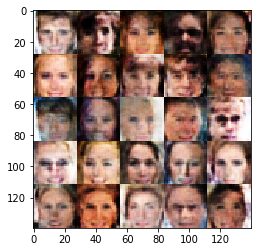

Epoch 1/1... Discriminator Loss: 1.091... Generator Loss: 0.821
Epoch 1/1... Discriminator Loss: 1.263... Generator Loss: 1.381
Epoch 1/1... Discriminator Loss: 0.986... Generator Loss: 0.983
Epoch 1/1... Discriminator Loss: 1.412... Generator Loss: 1.346
Epoch 1/1... Discriminator Loss: 0.997... Generator Loss: 1.732
Epoch 1/1... Discriminator Loss: 1.147... Generator Loss: 0.790
Epoch 1/1... Discriminator Loss: 1.514... Generator Loss: 0.350
Epoch 1/1... Discriminator Loss: 1.417... Generator Loss: 0.380
Epoch 1/1... Discriminator Loss: 1.357... Generator Loss: 0.530
Epoch 1/1... Discriminator Loss: 1.331... Generator Loss: 0.477


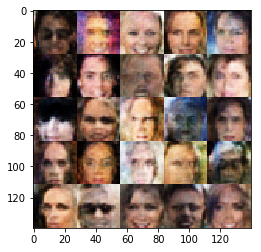

Epoch 1/1... Discriminator Loss: 1.322... Generator Loss: 0.458
Epoch 1/1... Discriminator Loss: 1.470... Generator Loss: 0.339
Epoch 1/1... Discriminator Loss: 1.517... Generator Loss: 0.340
Epoch 1/1... Discriminator Loss: 1.212... Generator Loss: 0.683
Epoch 1/1... Discriminator Loss: 1.331... Generator Loss: 0.982
Epoch 1/1... Discriminator Loss: 1.396... Generator Loss: 0.399


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.